# Model prediction

This notebooks creates grids with increasing patch sizes, and calculates segregation scores using index adapted from [Dogsa & Mandic-Mulec, 2023](https://doi.org/10.1016/j.bioflm.2023.100157).


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.integrate import trapezoid
from scipy.ndimage import label

# Colormap 
n_species = 2
cmap = plt.get_cmap('Spectral',n_species)  # You can choose any colormap, e.g., 'plasma', 'jet', 'coolwarm', etc.
colors = cmap(np.linspace(0, 1, n_species)) 

# main function to calculate segregation scores for point data
def calc_segregation_scores(im, window_sizes):
    '''
    Calculate segregation scores for focal species in image im over specified window sizes.
    
    Parameters:
    -----------
    im : np.ndarray
        2D array with species labels
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    Returns:
    --------
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    focal_type = 1 # Define index of focal species type
    other_type = 0 # Define index of non-focal species type

    # Calculate global frequency of focal species
    N_focal_G = np.sum(im == focal_type)
    N_other_G = np.sum(im == other_type)

    # Loop over all cells to calculate segregation scores
    nx, ny = im.shape
    segregation_scores = []
    for i in range(nx):
        for j in range(ny):
            if im[i,j] == focal_type:
                segregation_cell = np.empty(len(window_sizes))
                for idx, window_size in enumerate(window_sizes):
                    x0 = max(0, i - window_size)
                    x1 = min(nx, i + window_size + 1)
                    y0 = max(0, j - window_size)
                    y1 = min(ny, j + window_size + 1)

                    # calculate segregation score of focal cell
                    local_window = im[x0:x1, y0:y1]
                    N_focal_L = np.sum(local_window == focal_type) 
                    N_other_L  = np.sum(local_window == other_type)

                    if N_focal_L == 0 and N_other_L == 0:
                        seg_cell = np.nan
                    else:
                        seg_cell = np.abs(N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                    # calculate segregation score of focal cell
                    segregation_cell[idx] = seg_cell

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)

    non_nan_indices = ~np.isnan(mean_segregation)
    mean_segregation_nn = mean_segregation[non_nan_indices]
    window_sizes_nn = window_sizes[non_nan_indices]
    area = trapezoid(mean_segregation_nn, window_sizes_nn)
    # Calculate multiscale spatial segregation level
    MMSL = area / (window_sizes_nn[-1] - window_sizes_nn[0])


    return (MMSL, mean_segregation, std_segregation)


def create_random_patches_consensus(N, nx=51, ny=51, rx=1, ry=1, min_area=4, N_tr=2, seed=None):
    """
    Create random patches by iteratively making neighbors similar.
    
    Parameters:
    -----------
    N : int
        Number of iterations relative to grid size (actual iterations = N * nx * ny)
    nx, ny : int
        Grid dimensions (default 51x51)
    rx, ry : int
        Neighborhood radius in x and y directions (default 1)
    min_area : int
        Minimum area for patches to be retained (default 4)
    N_tr : int
        Number of types to consider for small patch removal (default 2)
        
    Returns:
    --------
    matrix : np.ndarray
        2D array with 0s and 1s showing patchy distribution
    """
    # Initialize matrix with random 0s and 1s at 1:1 ratio
    total_cells = nx * ny
    matrix = np.zeros((nx, ny), dtype=int)
    if seed is not None:
        np.random.seed(seed)
    ones_indices = np.random.choice(total_cells, size=total_cells//2, replace=False)
    matrix.flat[ones_indices] = 1
    
    # Define neighbor offsets (8-connected)
    neighbor_offsets = (-1,0,1)
    
    # Perform N*nx*ny iterations
    n_iterations = int(np.ceil(N * nx * ny))
    for _ in range(n_iterations):
        # Randomly select a point
        i = np.random.randint(0, nx)
        j = np.random.randint(0, ny)

        imin = max(0, i - rx)
        imax = min(nx, i + rx + 1)
        jmin = max(0, j - ry)
        jmax = min(ny, j + ry + 1)
        # Get neighbor values
        neighbor_values = matrix[imin:imax, jmin:jmax]
        # Determine majority value
        if np.sum(neighbor_values) > (neighbor_values.size / 2):
            majority_value = 1
        else:   
            majority_value = 0
        # Update selected point to majority value
        matrix[i, j] = majority_value

    # Remove small patches (< min_area pixels) using BW area filtering, for both cell types when N> N_tr
    if N > N_tr:
        # Process both types of patches
        for patch_type in [0, 1]:
            labeled, num_features = label(matrix == patch_type)
            
            # Find and remove small patches
            for region_id in range(1, num_features + 1):
                region_mask = labeled == region_id
                if np.sum(region_mask) < min_area:
                    # Assign small patch to the other cell type (opposite value)
                    matrix[region_mask] = 1 - patch_type
    
    return matrix



## Random Patches

total number of grids = 220


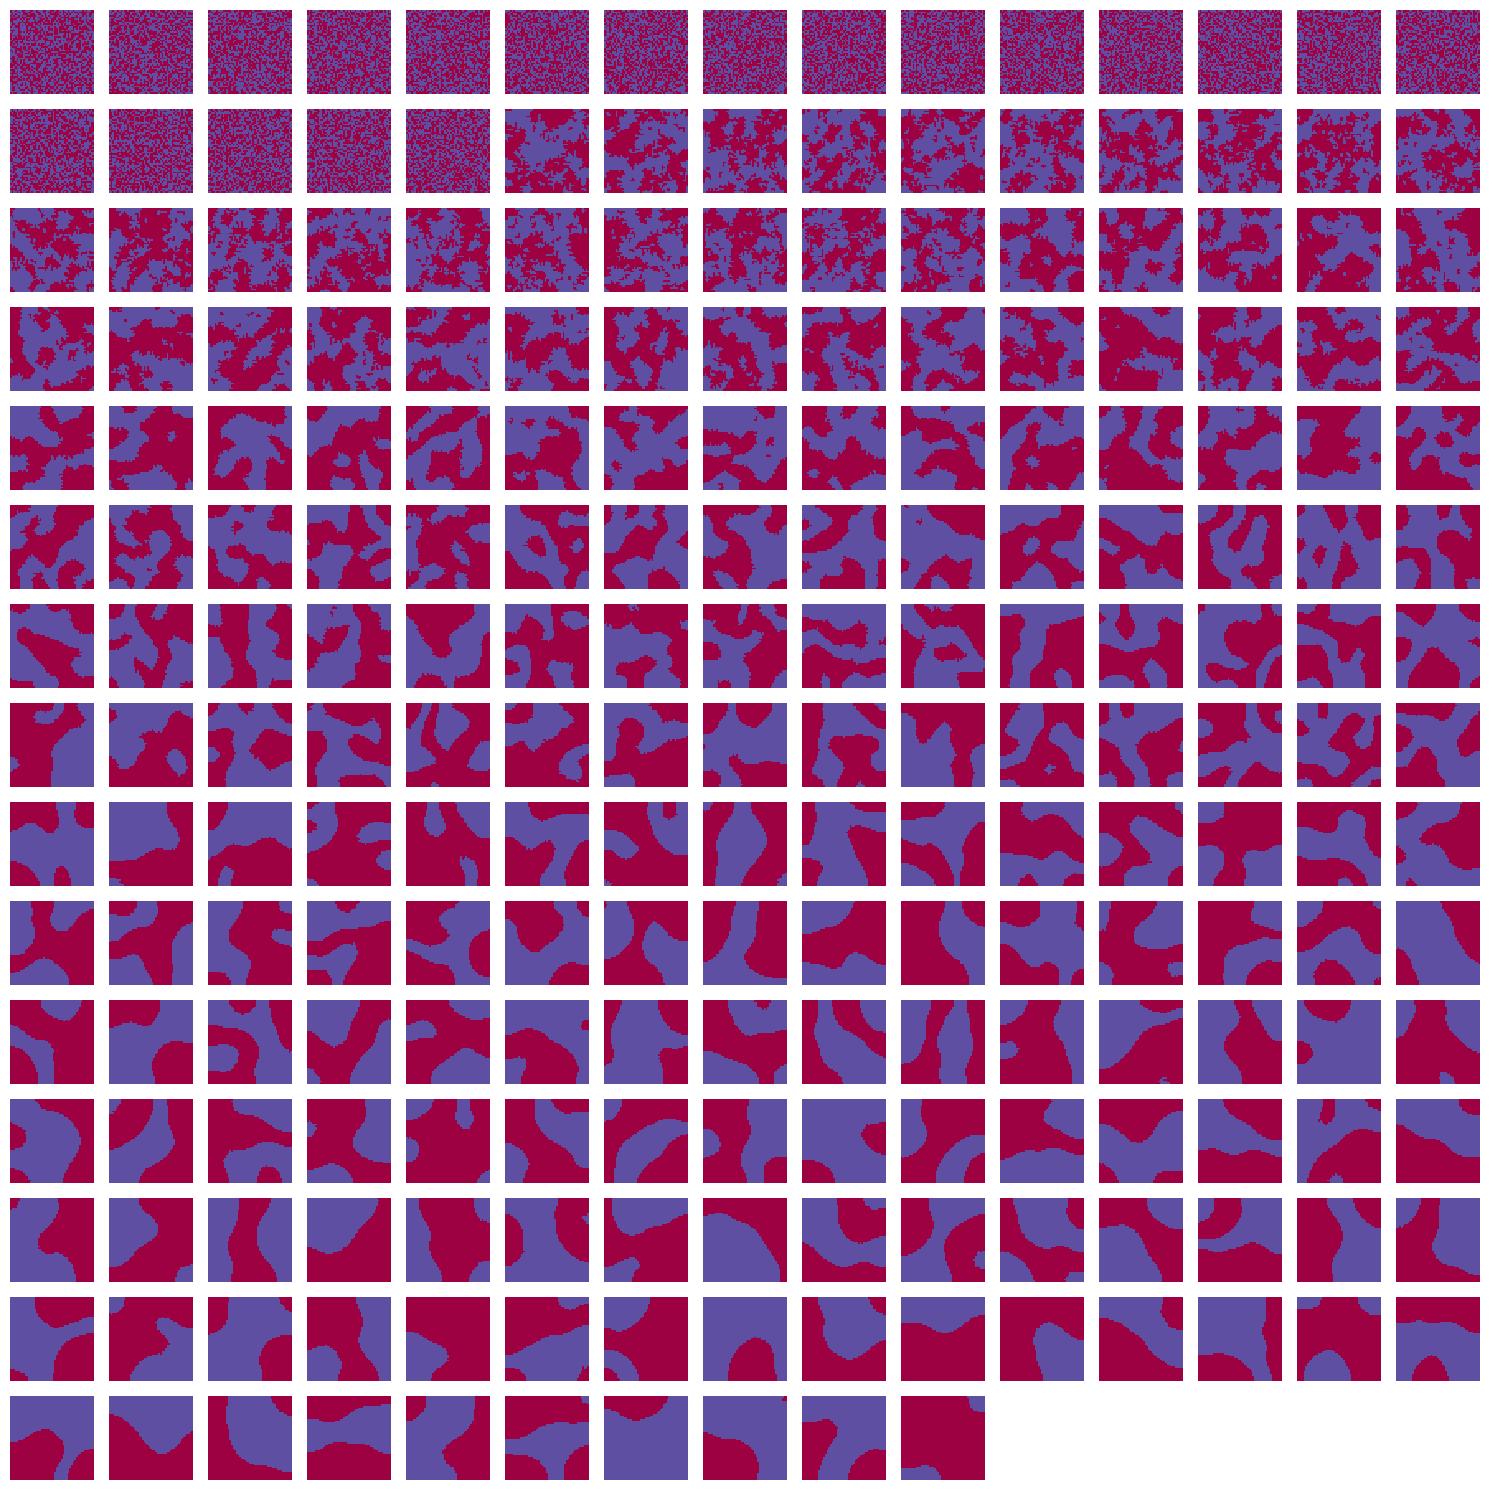

In [61]:
# Set parameters
nx, ny = 51, 51
rx = 3
ry = 3 
rxy_offset = [0]
N_values = [0,0.5,1,2,3,5,10,15,20,25,30]
n_replicates = 20
window_sizes = np.arange(1, 26, 1)

# Store all results
all_results = []

grids = []
# Run simulations
unique_id = 0
for N in N_values:
    for rep in range(n_replicates):
        for rxyo in rxy_offset:
            # Generate random patches
            matrix = create_random_patches_consensus(N, nx, ny, rx=rx+rxyo, ry=ry+rxyo, min_area=4, N_tr=0, seed=unique_id)

            # Calculate segregation scores
            MSSL, mean_seg, std_seg = calc_segregation_scores(matrix, window_sizes)
            
            # Store results
            for w_idx, w_size in enumerate(window_sizes):
                all_results.append({
                    'N': N,
                    'replicate': rep,
                    'rxy_offset': rxyo,
                    'unique_id' : unique_id,
                    'window_size': w_size,
                    'mean_segregation': mean_seg[w_idx],
                    'std_segregation': std_seg[w_idx],
                    'MSSL': MSSL})
            grids.append(matrix)
            unique_id += 1
# Convert to DataFrame
results_df = pd.DataFrame(all_results)

print(f"total number of grids = {len(grids)}")

# Plot example grids for each N value
n_grids = len(grids)
fig, axes = plt.subplots(15,15, figsize=(15, 15))
axes = axes.flatten()

for idx in range(n_grids):
    # Generate one example for visualization
 
    # Plot
    axes[idx].imshow(grids[idx], cmap=cmap, interpolation='nearest')
    axes[idx].axis('off')

# Remove any extra subplots
for idx in range(n_grids, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


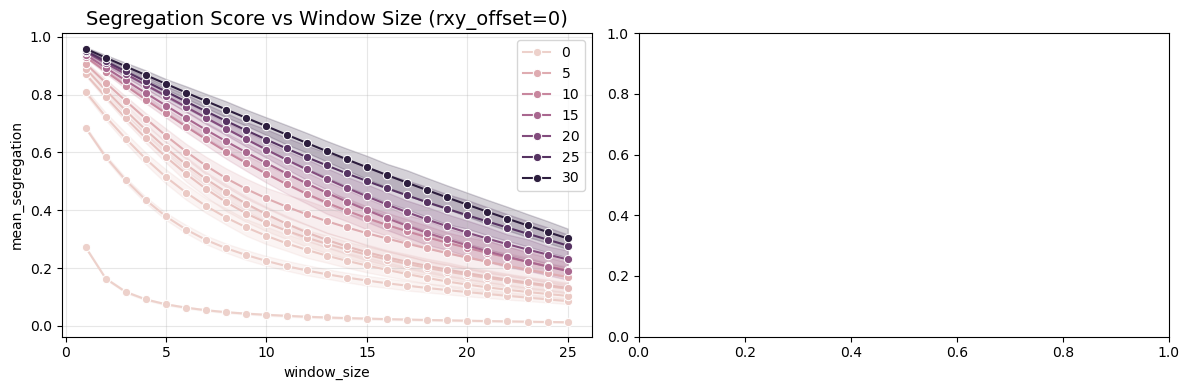

In [62]:
# Plot segregation scores vs window size for different N values
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for rxy_idx, rxyo in enumerate(rxy_offset):
    ax = axes[rxy_idx]

    data = results_df[(results_df['rxy_offset'] == rxyo)]

    sns.lineplot(data=data, x='window_size', y='mean_segregation', hue='N', marker='o', ax=ax)
    ax.set_title(f'Segregation Score vs Window Size (rxy_offset={rxyo})', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


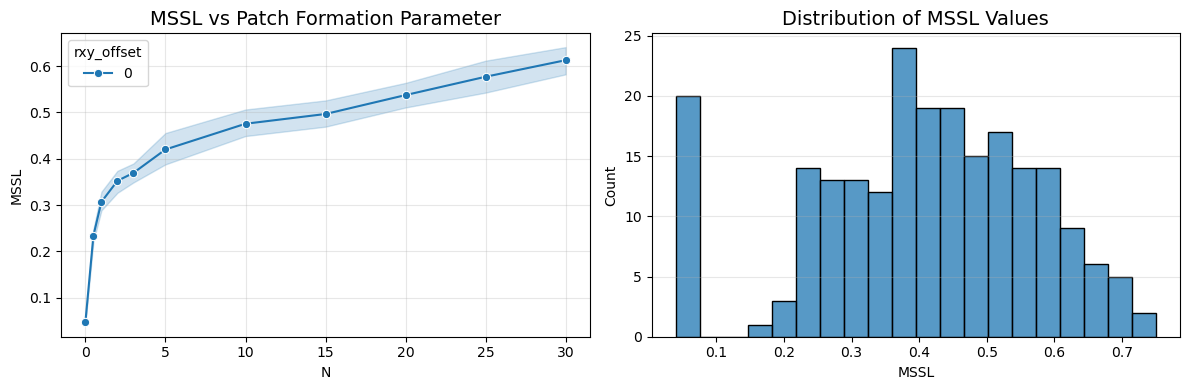

In [63]:
# create summary dataframe with unique_id, N, rxy_offset, MSSL
df_summary = results_df.groupby(['unique_id']).agg(
    N = ('N', 'first'),
    rxy_offset = ('rxy_offset', 'first'),
    replicate = ('replicate', 'first'),
    MSSL = ('MSSL', 'first')
).reset_index()


# Plot MSSL as function of N with different colors for rxy_offset
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: MSSL vs N
ax = axes[0]

sns.lineplot(data=df_summary, x='N', y='MSSL', hue='rxy_offset', marker='o', ax=ax)
ax.set_title('MSSL vs Patch Formation Parameter', fontsize=14)
ax.grid(True, alpha=0.3)

# Plot 2: Distribution of MSSL values
ax = axes[1]
sns.histplot(data=df_summary, x='MSSL', bins=20, edgecolor='black', ax=ax)
ax.set_title('Distribution of MSSL Values', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [54]:
#export results
df_summary.to_csv('data/model_mixed_chambers_segregation.csv', index=False)

#save grid images in pckl
import pickle
with open('data/model_mixed_chambers_grids.pkl', 'wb') as f:
    pickle.dump(grids, f)
